In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
import matplotlib.pyplot as plt

from tqdm import tqdm
import copy

pd.set_option('display.max_columns', 500)

In [2]:
BALL_VARS = ['ballx', 'bally']
HOME_VARS = ['p1x', 'p1y', 'p2x', 'p2y', 'p3x', 'p3y', 'p4x', 'p4y', 'p5x', 'p5y', 'p6x', 'p6y', 'p7x', 'p7y', 'p8x', 'p8y', 'p9x', 'p9y', 'p10x', 'p10y', 'p11x', 'p11y']
AWAY_VARS = ['p12x', 'p12y', 'p13x', 'p13y', 'p14x', 'p14y', 'p15x', 'p15y', 'p16x', 'p16y', 'p17x', 'p17y', 'p18x', 'p18y', 'p19x', 'p19y', 'p20x', 'p20y', 'p21x', 'p21y', 'p22x', 'p22y']
FRAME_VARS = [f.replace('x', 'dx').replace('y', 'dy') for f in BALL_VARS] + [f.replace('x', 'dx').replace('y', 'dy') for f in HOME_VARS] + [f.replace('x', 'dx').replace('y', 'dy') for f in AWAY_VARS]
CONTEXT_VARS = BALL_VARS + HOME_VARS + AWAY_VARS

In [3]:
N_CONTEXT_FRAMES = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading data

In [4]:
data = pd.read_feather('data/tracking2.feather')

In [5]:
features = []
# add context vars
i = 1
data_context = data.shift(i)
data_context.loc[data_context['gameId'] != data['gameId'], FRAME_VARS] = pd.NA
data_context = data_context[CONTEXT_VARS].add_prefix(f'c{i}_')
data = pd.concat([data, data_context], axis=1)
features += list(data_context.columns)
# add frame vars
for i in range(1, N_CONTEXT_FRAMES + 1):
    data_context = data.shift(i)
    data_context.loc[data_context['gameId'] != data['gameId'], FRAME_VARS] = pd.NA
    data_context = data_context[FRAME_VARS].add_prefix(f'c{i}_')
    data = pd.concat([data, data_context], axis=1)
    features += list(data_context.columns)

data = data.dropna()

In [6]:
data

,gameId,playId,frameId,is_after_snap,ballx,bally,balldx,balldy,p1x,p1y,p1dx,p1dy,p2x,p2y,p2dx,p2dy,p3x,p3y,p3dx,p3dy,p4x,p4y,p4dx,p4dy,p5x,p5y,p5dx,p5dy,p6x,p6y,p6dx,p6dy,p7x,p7y,p7dx,p7dy,p8x,p8y,p8dx,p8dy,p9x,p9y,p9dx,p9dy,p10x,p10y,p10dx,p10dy,p11x,p11y,p11dx,p11dy,p12x,p12y,p12dx,p12dy,p13x,p13y,p13dx,p13dy,p14x,p14y,p14dx,p14dy,p15x,p15y,p15dx,p15dy,p16x,p16y,p16dx,p16dy,p17x,p17y,p17dx,p17dy,p18x,p18y,p18dx,p18dy,p19x,p19y,p19dx,p19dy,p20x,p20y,p20dx,p20dy,p21x,p21y,p21dx,p21dy,p22x,p22y,p22dx,p22dy,c1_ballx,c1_bally,c1_p1x,c1_p1y,c1_p2x,c1_p2y,c1_p3x,c1_p3y,c1_p4x,c1_p4y,c1_p5x,c1_p5y,c1_p6x,c1_p6y,c1_p7x,c1_p7y,c1_p8x,c1_p8y,c1_p9x,c1_p9y,c1_p10x,c1_p10y,c1_p11x,c1_p11y,c1_p12x,c1_p12y,c1_p13x,c1_p13y,c1_p14x,c1_p14y,c1_p15x,c1_p15y,c1_p16x,c1_p16y,c1_p17x,c1_p17y,c1_p18x,c1_p18y,c1_p19x,c1_p19y,c1_p20x,c1_p20y,c1_p21x,c1_p21y,c1_p22x,c1_p22y,c1_balldx,c1_balldy,c1_p1dx,c1_p1dy,c1_p2dx,c1_p2dy,c1_p3dx,c1_p3dy,c1_p4dx,c1_p4dy,c1_p5dx,c1_p5dy,c1_p6dx,c1_p6dy,c1_p7dx,c1_p7dy,c1_p8dx,c1_p8dy,c1_p9dx,c1_p9dy,c1_p10dx,c1_p10dy,c1_p11dx,c1_p11dy,c1_p12dx,c1_p12dy,c1_p13dx,c1_p13dy,c1_p14dx,c1_p14dy,c1_p15dx,c1_p15dy,c1_p16dx,c1_p16dy,c1_p17dx,c1_p17dy,c1_p18dx,c1_p18dy,c1_p19dx,c1_p19dy,c1_p20dx,c1_p20dy,c1_p21dx,c1_p21dy,c1_p22dx,c1_p22dy
2,2022090800,56,3,False,0.710000,0.556098,-0.000083,0.000000,0.744000,0.553846,-0.000917,0.000188,0.736500,0.565103,-0.001750,-0.000563,0.758667,0.522326,-0.000167,-0.004690,0.745833,0.539587,-0.000917,-0.000938,0.753333,0.543902,-0.000417,-0.003752,0.757833,0.550657,0.000250,0.000375,0.763917,0.533208,0.000083,-0.002064,0.750667,0.616510,-0.001167,0.003002,0.740250,0.583490,-0.001417,0.000750,0.769750,0.520450,0.000500,-0.006567,0.746917,0.593621,-0.001500,0.001501,0.681083,0.537711,-0.000833,0.001313,0.690000,0.561914,-0.000417,0.001126,0.682417,0.458349,-0.000667,-0.001501,0.679000,0.618386,-0.000500,0.003189,0.691750,0.615760,-0.000167,0.002064,0.699000,0.547280,0.000000,0.000563,0.674250,0.472233,-0.000333,-0.002627,0.687333,0.545591,-0.000250,0.000563,0.667333,0.507505,-0.001167,-0.001313,0.664833,0.617636,-0.000667,0.002439,0.678500,0.567355,-0.000750,0.001126,0.710083,0.556098,0.744917,0.553659,0.738250,0.565666,0.758833,0.527017,0.746750,0.540525,0.753750,0.547655,0.757583,0.550281,0.763833,0.535272,0.751833,0.613508,0.741667,0.582739,0.769250,0.527017,0.748417,0.592120,0.681917,0.536398,0.690417,0.560788,0.683083,0.459850,0.679500,0.615197,0.691917,0.613696,0.699000,0.546717,0.674583,0.474859,0.687583,0.545028,0.668500,0.508818,0.665500,0.615197,0.679250,0.566229,0.000000,0.000000,-0.000750,-0.000188,-0.001750,-0.000750,-0.000167,-0.004690,-0.000917,-0.001126,-0.000417,-0.003752,0.000250,0.000375,0.000167,-0.001876,-0.001167,0.003002,-0.001417,0.000750,0.000500,-0.006191,-0.001250,0.001313,-0.000833,0.001313,-0.000417,0.000938,-0.000667,-0.001501,-0.000500,0.003377,-0.000167,0.002064,0.000083,0.000750,-0.000417,-0.002439,-0.000333,0.000375,-0.001083,-0.001126,-0.000667,0.002439,-0.000583,0.001501
3,2022090800,56,4,False,0.710000,0.556098,0.000000,0.000000,0.742917,0.553846,-0.001083,0.000000,0.734833,0.564353,-0.001667,-0.000750,0.758417,0.517824,-0.000250,-0.004503,0.744917,0.538837,-0.000917,-0.000750,0.752917,0.539775,-0.000417,-0.004128,0.758250,0.551407,0.000417,0.000750,0.764083,0.531332,0.000167,-0.001876,0.749500,0.619512,-0.001167,0.003002,0.738667,0.584240,-0.001583,0.000750,0.770083,0.513321,0.000333,-0.007129,0.745333,0.595497,-0.001583,0.001876,0.680167,0.538837,-0.000917,0.001126,0.689750,0.563227,-0.000250,0.001313,0.681750,0.456660,-0.000667,-0.001689,0.678417,0.621764,-0.000583,0.003377,0.691667,0.617824,-0.000083,0.002064,0.699000,0.548030,0.000000,0.000750,0.673917,0.469794,-0.000333,-0.002439,0.687250,0.546154,-0.000083,0.000563,0.666167,0.506191,-0.001167,-0.001313,0.664250,0.620075,-0.000583,0.002439,0.677750,0.568480,-0.000750,0.001126,0.710000,0.556098,0.744000,0.553846,0.736500,0.565103,0.758667,0.522326,0.745833,0.539587,0.753333,0.543902,0.757833,0.55065

In [7]:
data = data[data['is_after_snap'] == True]

In [8]:
for col in data.columns:
    print(col, data[col].dtype)

gameId int64
playId int64
frameId int64
is_after_snap bool
ballx float64
bally float64
balldx float64
balldy float64
p1x float64
p1y float64
p1dx float64
p1dy float64
p2x float64
p2y float64
p2dx float64
p2dy float64
p3x float64
p3y float64
p3dx float64
p3dy float64
p4x float64
p4y float64
p4dx float64
p4dy float64
p5x float64
p5y float64
p5dx float64
p5dy float64
p6x float64
p6y float64
p6dx float64
p6dy float64
p7x float64
p7y float64
p7dx float64
p7dy float64
p8x float64
p8y float64
p8dx float64
p8dy float64
p9x float64
p9y float64
p9dx float64
p9dy float64
p10x float64
p10y float64
p10dx float64
p10dy float64
p11x float64
p11y float64
p11dx float64
p11dy float64
p12x float64
p12y float64
p12dx float64
p12dy float64
p13x float64
p13y float64
p13dx float64
p13dy float64
p14x float64
p14y float64
p14dx float64
p14dy float64
p15x float64
p15y float64
p15dx float64
p15dy float64
p16x float64
p16y float64
p16dx float64
p16dy float64
p17x float64
p17y float64
p17dx float64
p17dy float64
p

In [9]:
print(features)

['c1_ballx', 'c1_bally', 'c1_p1x', 'c1_p1y', 'c1_p2x', 'c1_p2y', 'c1_p3x', 'c1_p3y', 'c1_p4x', 'c1_p4y', 'c1_p5x', 'c1_p5y', 'c1_p6x', 'c1_p6y', 'c1_p7x', 'c1_p7y', 'c1_p8x', 'c1_p8y', 'c1_p9x', 'c1_p9y', 'c1_p10x', 'c1_p10y', 'c1_p11x', 'c1_p11y', 'c1_p12x', 'c1_p12y', 'c1_p13x', 'c1_p13y', 'c1_p14x', 'c1_p14y', 'c1_p15x', 'c1_p15y', 'c1_p16x', 'c1_p16y', 'c1_p17x', 'c1_p17y', 'c1_p18x', 'c1_p18y', 'c1_p19x', 'c1_p19y', 'c1_p20x', 'c1_p20y', 'c1_p21x', 'c1_p21y', 'c1_p22x', 'c1_p22y', 'c1_balldx', 'c1_balldy', 'c1_p1dx', 'c1_p1dy', 'c1_p2dx', 'c1_p2dy', 'c1_p3dx', 'c1_p3dy', 'c1_p4dx', 'c1_p4dy', 'c1_p5dx', 'c1_p5dy', 'c1_p6dx', 'c1_p6dy', 'c1_p7dx', 'c1_p7dy', 'c1_p8dx', 'c1_p8dy', 'c1_p9dx', 'c1_p9dy', 'c1_p10dx', 'c1_p10dy', 'c1_p11dx', 'c1_p11dy', 'c1_p12dx', 'c1_p12dy', 'c1_p13dx', 'c1_p13dy', 'c1_p14dx', 'c1_p14dy', 'c1_p15dx', 'c1_p15dy', 'c1_p16dx', 'c1_p16dy', 'c1_p17dx', 'c1_p17dy', 'c1_p18dx', 'c1_p18dy', 'c1_p19dx', 'c1_p19dy', 'c1_p20dx', 'c1_p20dy', 'c1_p21dx', 'c1_p21dy

In [10]:
train_data = data[data['gameId'] < 2022101700]
val_data = data[(data['gameId'] >= 2022101700) & (data['gameId'] < 2022102400)]
test_data = data[data['gameId'] >= 2022102400]

# Modeling

In [11]:
# MDN Model Definition
class MDN(nn.Module):
    def __init__(self, input_dim, n_points, n_gaussians):
        super(MDN, self).__init__()

        self.n_points = n_points
        self.n_gaussians = n_gaussians

        self.fc1 = nn.Linear(input_dim, 1024)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(p=0.2)
        # self.fc3 = nn.Linear(1024, 1024)
        # self.dropout3 = nn.Dropout(p=0.2)
        self.fc_mu = nn.Linear(1024, n_points * n_gaussians * 2)   # Means
        self.fc_sigma = nn.Linear(1024, n_points * n_gaussians * 2) # Std deviations
        self.fc_pi = nn.Linear(1024, n_points * n_gaussians)        # Mixture weights

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        # x = torch.relu(self.fc3(x))
        # x = self.dropout3(x)
        mu = self.fc_mu(x).view(-1, self.n_points, self.n_gaussians, 2)
        sigma = F.softplus(self.fc_sigma(x)).view(-1, self.n_points, self.n_gaussians, 2)# + 1e-6
        pi = torch.softmax(self.fc_pi(x).view(-1, self.n_points, self.n_gaussians), dim=-1)
        return mu, sigma, pi

# Loss function
def mdn_nll_loss(y, mu, sigma, pi):
    m = dist.Normal(mu, sigma)
    log_prob = m.log_prob(y.unsqueeze(2))  # Add Gaussian components dimension
    log_prob = torch.sum(log_prob, dim=-1) # Sum over x and y dimensions
    weighted_log_prob = log_prob + torch.log(pi)
    nll = -torch.logsumexp(weighted_log_prob, dim=-1)  # Log-sum-exp over gaussians
    return nll.mean()

# Sampling function
def sample_from_mdn(mu, sigma, pi, n_samples=1):
    batch_size, n_points, n_gaussians, _ = mu.shape
    samples = []
    
    # for b in range(batch_size):
    #     point_samples = []
    #     for p in range(n_points):
    #         # Sample component
    #         categorical = dist.Categorical(pi[b, p])
    #         component = categorical.sample((n_samples,))
            
    #         # Sample from Gaussian
    #         chosen_mu = mu[b, p, component, :]
    #         chosen_sigma = sigma[b, p, component, :]

    #         normal_dist = dist.Normal(chosen_mu, chosen_sigma)
            
    #         # Sample n_samples from selected Gaussian component
    #         point_samples.append(normal_dist.sample())
        
    #     samples.append(torch.stack(point_samples).squeeze(1))

    for b in range(batch_size):
        point_samples = []
        for p in range(n_points):
            # Sample component
            categorical = dist.Categorical(pi[b, p])
            component = categorical.sample((n_samples,))
            
            # Sample from Gaussian
            chosen_mu = mu[b, p, component, :]
            chosen_sigma = sigma[b, p, component, :]

            # Check if elements in chosen_sigma are close to zero
            is_sigma_zero = torch.isclose(chosen_sigma, torch.zeros_like(chosen_sigma))
            
            # Set sigma to 1 temporarily where it's close to zero to avoid errors during sampling
            safe_sigma = torch.where(is_sigma_zero, torch.ones_like(chosen_sigma), chosen_sigma)
            
            # Sample from Normal distribution with safe_sigma
            normal_dist = dist.Normal(chosen_mu, safe_sigma)
            samples_for_point = normal_dist.sample()
            
            # Replace values where sigma was originally close to zero with mean
            samples_for_point = torch.where(is_sigma_zero, chosen_mu, samples_for_point)
            
            point_samples.append(samples_for_point)

        samples.append(torch.stack(point_samples).squeeze(1))
    
    return torch.stack(samples)  # Shape: (batch_size, n_points, n_samples, 2)

In [12]:
len(features)

92

In [13]:
# Parameters
n_points = 23 # 23 elements on the field
input_dim = n_points * 2 * N_CONTEXT_FRAMES + len(CONTEXT_VARS) # Flattened x, y coordinates of all points * number of context frames
n_gaussians = 3 # Number of mixture components
output_dim = 11 * 2 * 2 * n_gaussians # 11 players * 2 teams * 2 coordinates * n_gaussians per point

In [14]:
x_train = torch.tensor(train_data[features].values, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(train_data[FRAME_VARS].values, dtype=torch.float32).view(-1, n_points, 2).to(DEVICE)
x_val = torch.tensor(val_data[features].values, dtype=torch.float32).to(DEVICE)
y_val = torch.tensor(val_data[FRAME_VARS].values, dtype=torch.float32).view(-1, n_points, 2).to(DEVICE)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [15]:
# Training the model
model = MDN(input_dim=input_dim, n_points=n_points, n_gaussians=n_gaussians).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 25

In [16]:
for epoch in range(n_epochs):
    for x_train, y_train in tqdm(train_loader):
        optimizer.zero_grad()
        mu, sigma, pi = model(x_train)
        loss = mdn_nll_loss(y_train, mu, sigma, pi)
        loss.backward()
        optimizer.step()
        
    if ((epoch % 1)) == 0:
        val_loss = 0
        for x_val, y_val in val_loader:
            mu, sigma, pi = model(x_val)
            val_loss += mdn_nll_loss(y_val, mu, sigma, pi).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

100%|██████████| 591/591 [00:05<00:00, 102.06it/s]


Epoch 0, Loss: -6.7240, Val Loss: -7.7192


100%|██████████| 591/591 [00:05<00:00, 105.29it/s]


Epoch 1, Loss: -8.5518, Val Loss: -8.5278


100%|██████████| 591/591 [00:06<00:00, 95.50it/s] 


Epoch 2, Loss: -8.5069, Val Loss: -8.5590


100%|██████████| 591/591 [00:06<00:00, 98.44it/s] 


Epoch 3, Loss: -9.0211, Val Loss: -8.9690


100%|██████████| 591/591 [00:05<00:00, 102.69it/s]


Epoch 4, Loss: -9.0021, Val Loss: -8.9665


100%|██████████| 591/591 [00:05<00:00, 100.34it/s]


Epoch 5, Loss: -9.3001, Val Loss: -9.2387


100%|██████████| 591/591 [00:06<00:00, 92.31it/s] 


Epoch 6, Loss: -9.4453, Val Loss: -9.4045


100%|██████████| 591/591 [00:06<00:00, 95.57it/s] 


Epoch 7, Loss: -9.3669, Val Loss: -9.4408


100%|██████████| 591/591 [00:06<00:00, 97.81it/s] 


Epoch 8, Loss: -9.4226, Val Loss: -9.3963


100%|██████████| 591/591 [00:06<00:00, 93.42it/s] 


Epoch 9, Loss: -9.4978, Val Loss: -9.5054


100%|██████████| 591/591 [00:05<00:00, 100.94it/s]


Epoch 10, Loss: -9.5171, Val Loss: -9.4827


100%|██████████| 591/591 [00:06<00:00, 95.74it/s] 


Epoch 11, Loss: -9.6996, Val Loss: -9.5474


100%|██████████| 591/591 [00:06<00:00, 98.35it/s] 


Epoch 12, Loss: -9.6401, Val Loss: -9.6472


100%|██████████| 591/591 [00:05<00:00, 99.56it/s] 


Epoch 13, Loss: -9.7116, Val Loss: -9.6633


100%|██████████| 591/591 [00:06<00:00, 96.94it/s] 


Epoch 14, Loss: -9.8153, Val Loss: -9.7498


100%|██████████| 591/591 [00:06<00:00, 96.87it/s] 


Epoch 15, Loss: -9.8228, Val Loss: -9.6163


100%|██████████| 591/591 [00:06<00:00, 97.87it/s] 


Epoch 16, Loss: -9.7881, Val Loss: -9.7808


100%|██████████| 591/591 [00:05<00:00, 98.84it/s] 


Epoch 17, Loss: -9.8527, Val Loss: -9.8444


100%|██████████| 591/591 [00:06<00:00, 97.81it/s] 


Epoch 18, Loss: -9.9642, Val Loss: -9.9227


100%|██████████| 591/591 [00:06<00:00, 98.31it/s] 


Epoch 19, Loss: -9.8963, Val Loss: -9.9061


100%|██████████| 591/591 [00:05<00:00, 99.37it/s] 


Epoch 20, Loss: -9.8955, Val Loss: -9.9125


100%|██████████| 591/591 [00:06<00:00, 97.89it/s] 


Epoch 21, Loss: -10.0213, Val Loss: -9.9481


100%|██████████| 591/591 [00:05<00:00, 99.07it/s] 


Epoch 22, Loss: -9.9828, Val Loss: -9.9636


100%|██████████| 591/591 [00:06<00:00, 98.03it/s] 


Epoch 23, Loss: -10.0255, Val Loss: -10.0147


100%|██████████| 591/591 [00:06<00:00, 95.11it/s] 


Epoch 24, Loss: -9.9755, Val Loss: -9.9753


# Plotting

In [17]:
play_data = val_data[(val_data['gameId'] == 2022101700) & (val_data['playId'] == 90)]
play_data.shape

(53, 188)

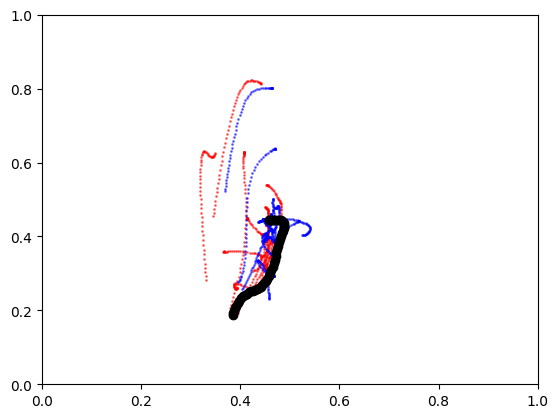

In [18]:
for i in range(1, 23):
    plt.plot(play_data[f'p{i}x'], play_data[f'p{i}y'], '.', color='red' if i <= 11 else 'blue', markersize=2, alpha=0.5)
plt.plot(play_data['ballx'], play_data['bally'], 'o', color='black')
plt.xlim(0, 1);
plt.ylim(0, 1);

In [76]:
frames = []

current_frame = play_data.iloc[0][features].values.tolist()
for i in tqdm(range(play_data.shape[0])):
    x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE).unsqueeze(0)
    mu, sigma, pi = model(x)
    samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(2).detach().cpu().numpy()
    # Sum the sample with the current frame to get the next frame
    current_frame[:n_points * 2] += samples.flatten()
    # shift the context frames
    current_frame = np.concat([current_frame[:n_points * 2], samples.flatten(), current_frame[2 * n_points * 2:]])
    frames.append(current_frame[:n_points * 2])
    
frames = pd.DataFrame(frames, columns=CONTEXT_VARS)

100%|██████████| 53/53 [00:01<00:00, 35.52it/s]


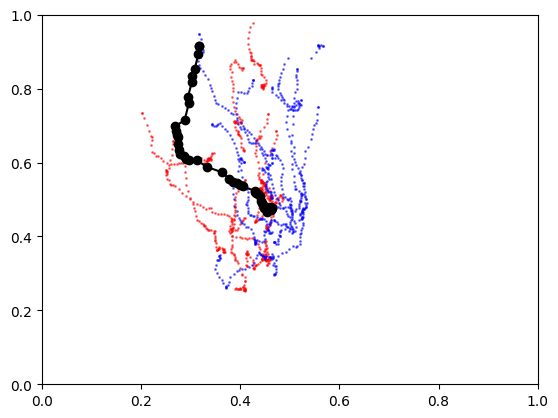

In [77]:
for i in range(1, 23):
    plt.plot(frames[f'p{i}x'], frames[f'p{i}y'], '.', color='red' if i <= 11 else 'blue', markersize=2, alpha=0.5)
plt.plot(frames['ballx'], frames['bally'], color='black', marker='o')
plt.xlim(0, 1);
plt.ylim(0, 1);

In [103]:
ball_positions_in_lookahead_10, ball_positions_in_lookahead_20, ball_positions_in_lookahead_30, ball_positions_in_lookahead_40 = [], [], [], []
max_lookahead = 40
for i in tqdm(range(100)):
    current_frame = play_data.iloc[0][features].values.tolist()
    for i in range(max_lookahead + 1):
        x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE).unsqueeze(0)
        mu, sigma, pi = model(x)
        samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(2).detach().cpu().numpy()
        # Sum the sample with the current frame to get the next frame
        current_frame[:n_points * 2] += samples.flatten()
        # shift the context frames
        current_frame = np.concat([current_frame[:n_points * 2], samples.flatten(), current_frame[2 * n_points * 2:]])
        if i == 10:
            ball_positions_in_lookahead_10.append(current_frame[:2])
        if i == 20:
            ball_positions_in_lookahead_20.append(current_frame[:2])
        if i == 30:
            ball_positions_in_lookahead_30.append(current_frame[:2])
        if i == 40:
            ball_positions_in_lookahead_40.append(current_frame[:2])

100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


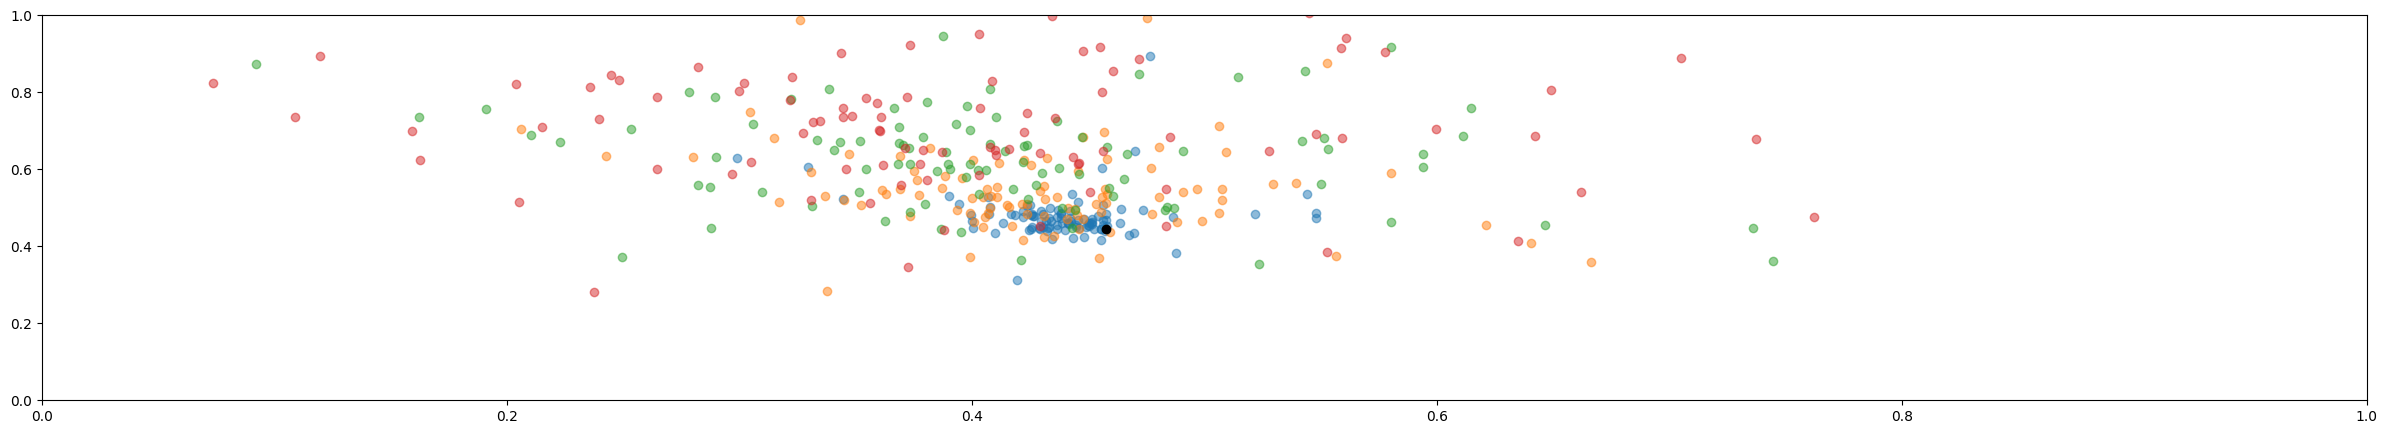

In [104]:
for i, ball_positions_in_lookahead in enumerate([ball_positions_in_lookahead_10, ball_positions_in_lookahead_20, ball_positions_in_lookahead_30, ball_positions_in_lookahead_40]):
    lookahead_data = pd.DataFrame(ball_positions_in_lookahead, columns=['ballx', 'bally'])
    plt.scatter(lookahead_data['ballx'], lookahead_data['bally'], c=f'C{i}', alpha=0.5)
plt.scatter(play_data.iloc[0]['ballx'], play_data.iloc[0]['bally'], c='black')
plt.xlim(0, 1);
plt.ylim(0, 1);

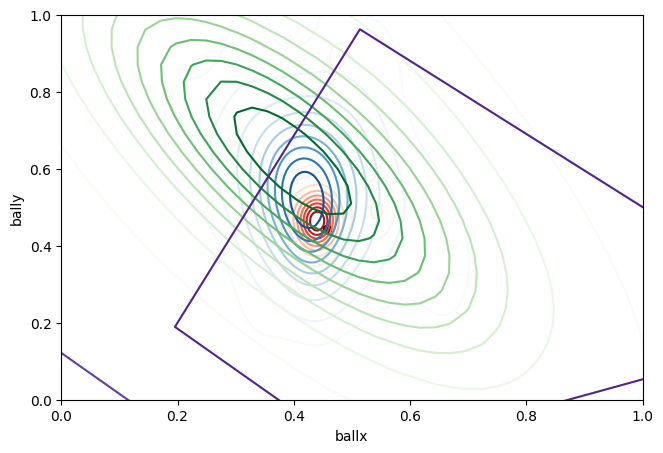

In [108]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [7.5, 5]
cmaps = ['Reds', 'Blues', 'Greens', 'Purples']
for i, ball_positions_in_lookahead in enumerate([ball_positions_in_lookahead_10, ball_positions_in_lookahead_20, ball_positions_in_lookahead_30, ball_positions_in_lookahead_40]):
    lookahead_data = pd.DataFrame(ball_positions_in_lookahead, columns=['ballx', 'bally'])
    sns.kdeplot(x=lookahead_data['ballx'], y=lookahead_data['bally'], cmap=cmaps[i])
plt.scatter(play_data.iloc[0]['ballx'], play_data.iloc[0]['bally'], c='black')
plt.xlim(0, 1);
plt.ylim(0, 1);

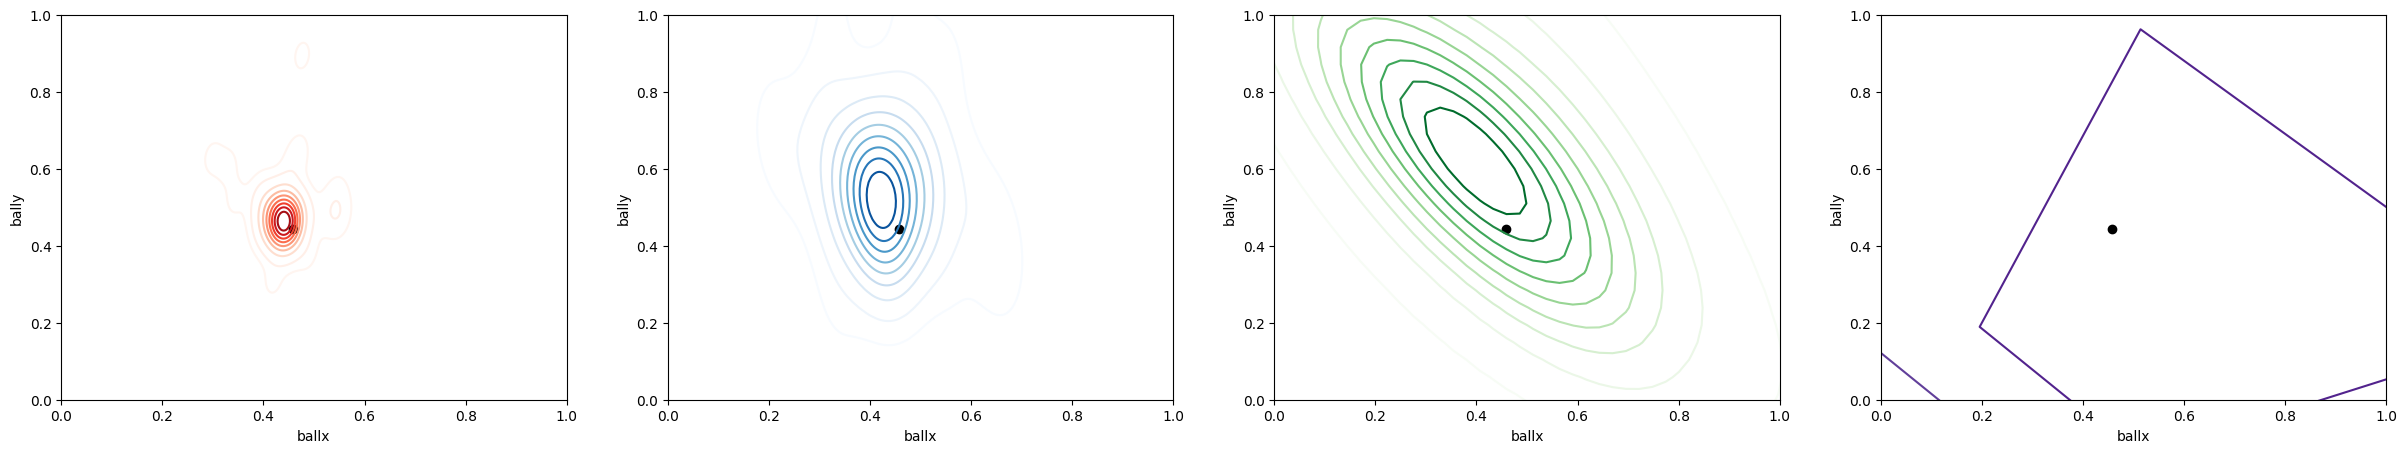

In [106]:
plt.rcParams['figure.figsize'] = [30, 5]
cmaps = ['Reds', 'Blues', 'Greens', 'Purples']
for i, ball_positions_in_lookahead in enumerate([ball_positions_in_lookahead_10, ball_positions_in_lookahead_20, ball_positions_in_lookahead_30, ball_positions_in_lookahead_40]):
    plt.subplot(1, 4, i+1)
    lookahead_data = pd.DataFrame(ball_positions_in_lookahead, columns=['ballx', 'bally'])
    sns.kdeplot(x=lookahead_data['ballx'], y=lookahead_data['bally'], cmap=cmaps[i])
    plt.scatter(play_data.iloc[0]['ballx'], play_data.iloc[0]['bally'], c='black')
    plt.xlim(0, 1);
    plt.ylim(0, 1);

In [107]:
current_frame = play_data.iloc[0][features].values
x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE).unsqueeze(0)
mu, sigma, pi = model(x)
mu.flatten()

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
current_frame.round(4)

array([ 7.100e-01,  5.561e-01,  7.429e-01,  5.538e-01,  7.348e-01,
        5.644e-01,  7.584e-01,  5.178e-01,  7.449e-01,  5.388e-01,
        7.529e-01,  5.398e-01,  7.582e-01,  5.514e-01,  7.641e-01,
        5.313e-01,  7.495e-01,  6.195e-01,  7.387e-01,  5.842e-01,
        7.701e-01,  5.133e-01,  7.453e-01,  5.955e-01,  6.802e-01,
        5.388e-01,  6.898e-01,  5.632e-01,  6.818e-01,  4.567e-01,
        6.784e-01,  6.218e-01,  6.917e-01,  6.178e-01,  6.990e-01,
        5.480e-01,  6.739e-01,  4.698e-01,  6.872e-01,  5.462e-01,
        6.662e-01,  5.062e-01,  6.642e-01,  6.201e-01,  6.778e-01,
        5.685e-01,  0.000e+00,  0.000e+00, -1.100e-03,  0.000e+00,
       -1.700e-03, -8.000e-04, -2.000e-04, -4.500e-03, -9.000e-04,
       -8.000e-04, -4.000e-04, -4.100e-03,  4.000e-04,  8.000e-04,
        2.000e-04, -1.900e-03, -1.200e-03,  3.000e-03, -1.600e-03,
        8.000e-04,  3.000e-04, -7.100e-03, -1.600e-03,  1.900e-03,
       -9.000e-04,  1.100e-03, -2.000e-04,  1.300e-03, -7.000e

In [ ]:
sigma.flatten()

tensor([0.0043, 0.0058, 0.0017, 0.0018, 0.0034, 0.0051, 0.0058, 0.0072, 0.0011,
        0.0020, 0.0034, 0.0046, 0.0014, 0.0028, 0.0012, 0.0022, 0.0026, 0.0062,
        0.0031, 0.0065, 0.0010, 0.0015, 0.0020, 0.0046, 0.0488, 0.0151, 0.0039,
        0.0088, 0.0011, 0.0024, 0.0071, 0.0071, 0.0009, 0.0020, 0.0064, 0.0088,
        0.0194, 0.0060, 0.0010, 0.0023, 0.0057, 0.0045, 0.0072, 0.0080, 0.0404,
        0.0194, 0.0011, 0.0021, 0.0038, 0.0033, 0.0017, 0.0024, 0.0015, 0.0024,
        0.0226, 0.0131, 0.0009, 0.0016, 0.0042, 0.0065, 0.0022, 0.0043, 0.0089,
        0.0152, 0.0009, 0.0014, 0.0054, 0.0087, 0.0140, 0.0077, 0.0011, 0.0023,
        0.0085, 0.0098, 0.0014, 0.0019, 0.0013, 0.0024, 0.0074, 0.0075, 0.0018,
        0.0030, 0.0020, 0.0024, 0.0013, 0.0023, 0.0029, 0.0062, 0.0029, 0.0037,
        0.0316, 0.0190, 0.0065, 0.0120, 0.0011, 0.0033, 0.0013, 0.0023, 0.0052,
        0.0075, 0.0014, 0.0028, 0.0014, 0.0025, 0.0046, 0.0063, 0.0015, 0.0021,
        0.0012, 0.0026, 0.0019, 0.0037, 

In [ ]:
mu.flatten().detach().cpu().numpy() - current_frame.round(4)

ValueError: operands could not be broadcast together with shapes (138,) (184,) 